In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy.stats import truncnorm
import matplotlib.pylab as pylab
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from scipy.stats import zscore
import xgboost as xgb
import lightgbm as lgb
import joblib

## Phân Tích

In [58]:
#tạo DataFrame với các cột đã được số hóa
df_raw = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/batdongsan/numerized/NhaO_numerized-dataset.csv',index_col=False)

In [71]:
df_capped = df_raw.copy()
rows  = df_capped[df_capped['MucGia'] < 200000000]
df_capped = df_capped.drop(index = rows.index)
rows  = df_capped[df_capped['MucGia'] > 200000000000]
df_capped = df_capped.drop(index = rows.index)

df_capped = df_capped.dropna(subset=['City', 'District', 'Ward','MucGia','SoTang','SoPhongNgu','SoToilet'])

df_capped = df_capped.drop(columns=['DiaChi','HuongBanCong','Lat','Long'])


In [72]:
df_capped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   City        24205 non-null  float64
 2   District    24205 non-null  float64
 3   MucGia      24205 non-null  float64
 4   MatTien     17245 non-null  float64
 5   PhapLy      22027 non-null  float64
 6   DuongVao    15305 non-null  float64
 7   HuongNha    7950 non-null   float64
 8   SoTang      24205 non-null  float64
 9   SoPhongNgu  24205 non-null  float64
 10  SoToilet    24205 non-null  float64
 11  NoiThat     17227 non-null  float64
 12  Ward        24205 non-null  float64
dtypes: float64(13)
memory usage: 2.6 MB


In [73]:
# Hàm để sinh giá trị ngẫu nhiên có giới hạn trong khoảng cố định
def truncated_normal(mean, std, lower, upper, size):
    return truncnorm(
        (lower - mean) / std, (upper - mean) / std, loc=mean, scale=std).rvs(size)

# Hàm để điền các giá trị bị thiếu trong một cột số
def fill_missing_with_random(column):
    if column.dtype.kind in 'biufc':  # Kiểm tra nếu cột là số
        # Tính trung bình và độ lệch chuẩn của cột (bỏ qua giá trị bị thiếu)
        mean = np.mean(column.dropna())
        std = np.std(column.dropna())
        
        # Xác định vị trí các giá trị bị thiếu
        missing_indices = np.where(column.isnull())[0]
        
        # Sinh giá trị ngẫu nhiên nếu cột đó có các giá trị là giá trị phân loại (như số cho 8 hướng)
        if column.name == 'HuongNha':
            random_data = truncated_normal(mean, std, 1, 8, len(missing_indices))
        elif column.name == 'NoiThat':
            random_data = truncated_normal(mean, std, 0, 3, len(missing_indices))
        else:
            # Sinh giá trị ngẫu nhiên từ phân phối chuẩn
            random_data = np.random.normal(loc=mean, scale=std, size=len(missing_indices))
            # Đảm bảo không có giá trị âm
            random_data = np.abs(random_data)
        
        # Điền giá trị bị thiếu bằng các giá trị ngẫu nhiên đã sinh ra
        column.iloc[missing_indices] = random_data
        
    return column

def zero_round(value):
    if value < 0.5:
        return 0
    elif value < 1:
        return 1
    else:
        return np.floor(value)

df_capped['HuongNha'] = fill_missing_with_random(df_capped['HuongNha'])
df_capped['NoiThat'] = fill_missing_with_random(df_capped['NoiThat'])
df_capped['PhapLy'] = fill_missing_with_random(df_capped['PhapLy'])

# Làm tròn giá trị cho cột NoiThat, PhapLy, HuongNha
df_capped['NoiThat'] = df_capped['NoiThat'].apply(zero_round)
df_capped['PhapLy'] = df_capped['PhapLy'].apply(zero_round)
df_capped['HuongNha'] = np.floor(df_capped['HuongNha'])



In [74]:
#thêm cột USD để về sau xây dựng mô hình với giá USD hạn chế được sai số do VND quá lớn (tỉ giá đổi 25k / 1$)
df_capped['USD']=df_capped['MucGia'].astype(float)/25000
df_capped.drop(columns='MucGia',inplace=True)

In [75]:
df_capped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   City        24205 non-null  float64
 2   District    24205 non-null  float64
 3   MatTien     17245 non-null  float64
 4   PhapLy      24205 non-null  float64
 5   DuongVao    15305 non-null  float64
 6   HuongNha    24205 non-null  float64
 7   SoTang      24205 non-null  float64
 8   SoPhongNgu  24205 non-null  float64
 9   SoToilet    24205 non-null  float64
 10  NoiThat     24205 non-null  float64
 11  Ward        24205 non-null  float64
 12  USD         24205 non-null  float64
dtypes: float64(13)
memory usage: 2.6 MB


In [76]:
# Thiết kế biểu đồ
rcParams = {'xtick.labelsize':'14','ytick.labelsize':'14','axes.labelsize':'16'}

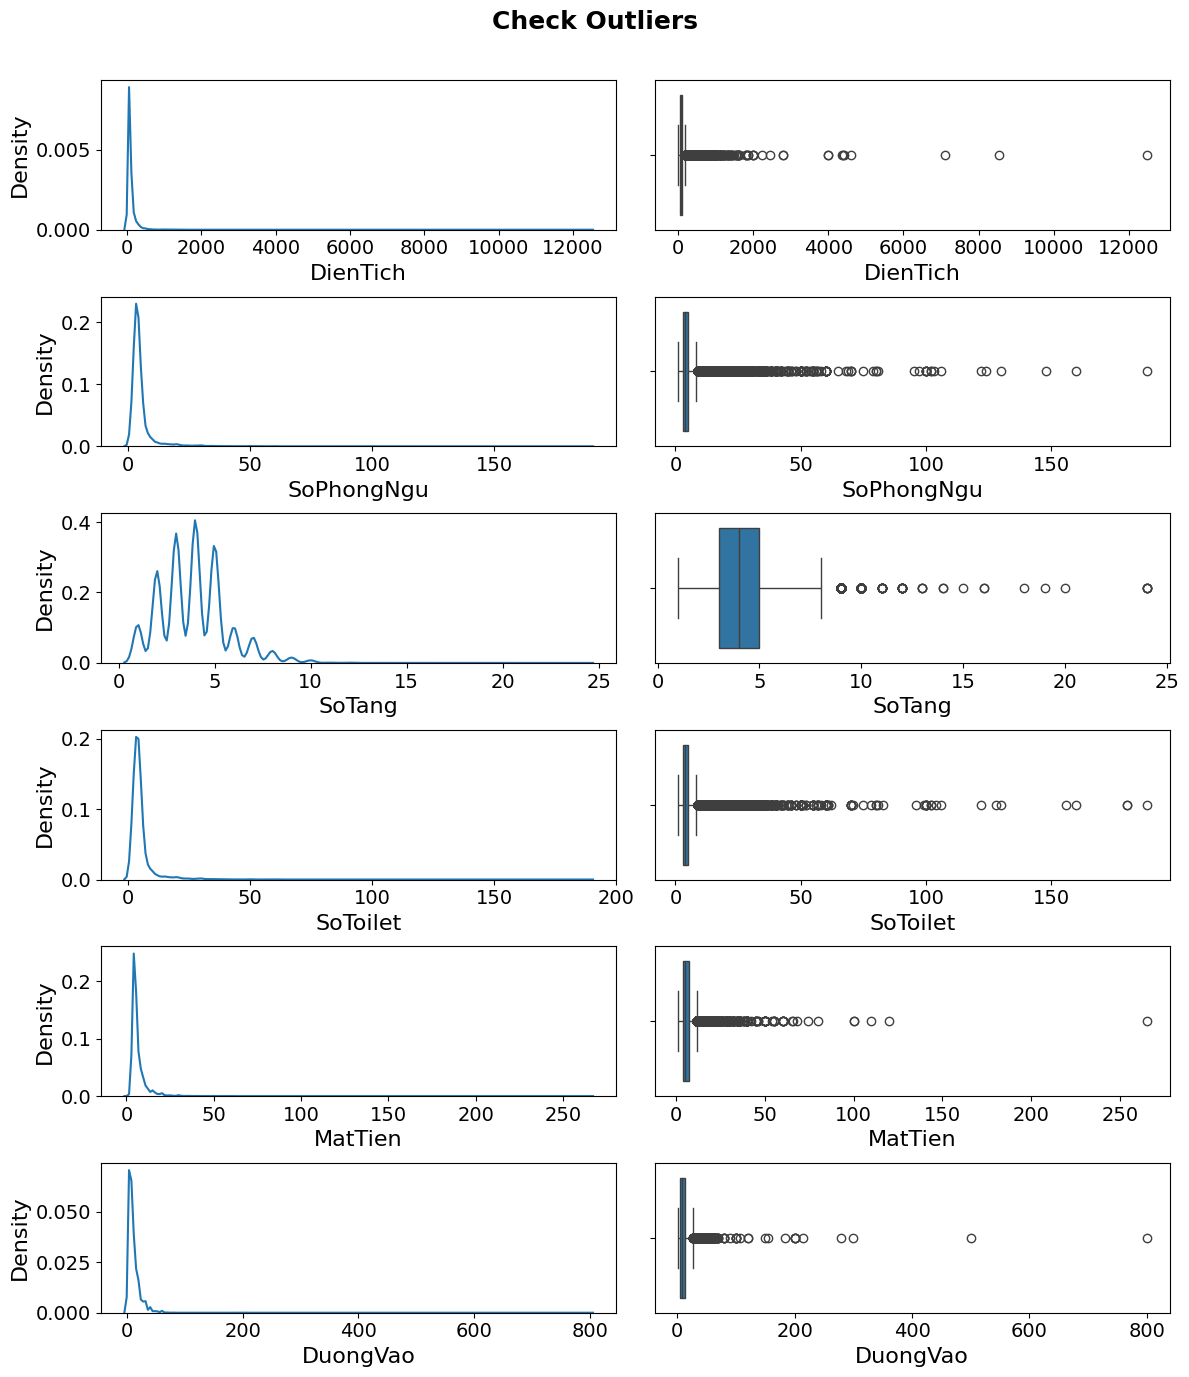

In [77]:
fig, ax = plt.subplots(6,2, figsize = (12,14))

fig.suptitle('Check Outliers', size = 18, fontweight="bold")
sns.kdeplot(ax= ax[0,0], data = df_capped, x = 'DienTich')
sns.boxplot(ax= ax[0,1], data = df_capped, x = 'DienTich')
sns.kdeplot(ax= ax[1,0], data = df_capped, x = 'SoPhongNgu')
sns.boxplot(ax= ax[1,1], data = df_capped, x = 'SoPhongNgu')
sns.kdeplot(ax= ax[2,0], data = df_capped, x = 'SoTang')
sns.boxplot(ax= ax[2,1], data = df_capped, x = 'SoTang')
sns.kdeplot(ax= ax[3,0], data = df_capped, x = 'SoToilet')
sns.boxplot(ax= ax[3,1], data = df_capped, x = 'SoToilet')
sns.kdeplot(ax= ax[4,0], data = df_capped, x = 'MatTien')
sns.boxplot(ax= ax[4,1], data = df_capped, x = 'MatTien')
sns.kdeplot(ax= ax[5,0], data = df_capped, x = 'DuongVao')
sns.boxplot(ax= ax[5,1], data = df_capped, x = 'DuongVao')


pylab.rcParams.update(rcParams)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

In [101]:
df_capped.describe(percentiles=[0.1,0.98])

,DienTich,City,District,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward,USD
count,24205.000000,24205.000000,24205.000000,17245.000000,24205.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,2.420500e+04
mean,107.193584,42.764264,433.928445,6.506114,1.089238,11.098968,4.518281,3.897583,5.297335,5.254617,1.873580,15532.489899,6.660946e+05
std,172.320227,36.598464,344.943141,5.251218,0.535211,13.343213,1.867371,1.752670,5.997421,6.296579,0.736503,12223.951486,8.682711e+05
min,0.280000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.200000e+04
10%,36.000000,1.000000,4.000000,3.900000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,145.000000,1.400000e+05
50%,73.500000,54.000000,555.000000,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000,3.800000e+05
98%,430.000000,79.000000,786.000000,20.000000,4.000000,40.000000,8.000000,8.000000,22.000000,22.000000,3.000000,27646.000000,3.560000e+06
max,12468.000000,96.000000,964.000000,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000,8.000000e+06


In [79]:
# df_capped = df_capped[(df_capped['DienTich']>=36) & (df_capped['DienTich']<=290)]
# df_capped = df_capped[(df_capped['MatTien']>=3) & (df_capped['MatTien']<=15)]
# df_capped = df_capped[(df_capped['DuongVao']>=3) & (df_capped['DuongVao']<=30)]
# df_capped = df_capped[(df_capped['SoTang']>=1) & (df_capped['SoTang']<=10)]
# df_capped = df_capped[(df_capped['SoPhongNgu']>=1) & (df_capped['SoPhongNgu']<=13)]
# df_capped = df_capped[(df_capped['SoToilet']>=1) & (df_capped['SoToilet']<=13)]
# df_capped.info()

Diện Tích: tập trung nhiều trong khoảng dưới 1000 m2  
Số Phòng Ngủ: khoảng dưới 13 phòng  
Số Tầng: dưới 8 tầng  
Số Toilet: dưới 13 phòng  
Mặt Tiền: dưới 20 m  
Đường Vào: dưới 40 m  
Diện Tích, Số Phòng Ngủ, Số Toilet, Mặt Tiền, Đường Vào có nhiều giá trị lớn vượt giá trị tập trung min-max (outlier)

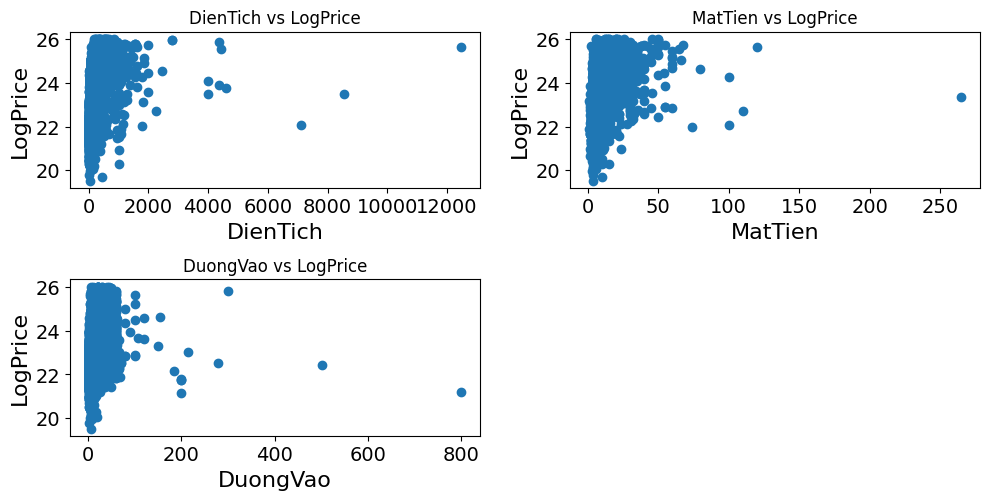

In [80]:
def scatter(x,fig):
    plt.subplot(5,2,fig)
    plt.scatter(df_capped[x],df_capped['USD'])
    plt.title(x+' vs USD')
    plt.ylabel('USD')
    plt.xlabel(x)


plt.figure(figsize=(10,12))


scatter('DienTich', 1)
scatter('MatTien', 2)
scatter('DuongVao', 3)
plt.tight_layout()

Diện tích, mặt tiền, đường vào có ảnh hưởng đến mức giá. vẫn có 1 vài điểm giá trị ngoại lệ có thể là giá trị rác, hoặc do ảnh hưởng bởi các nhãn khác

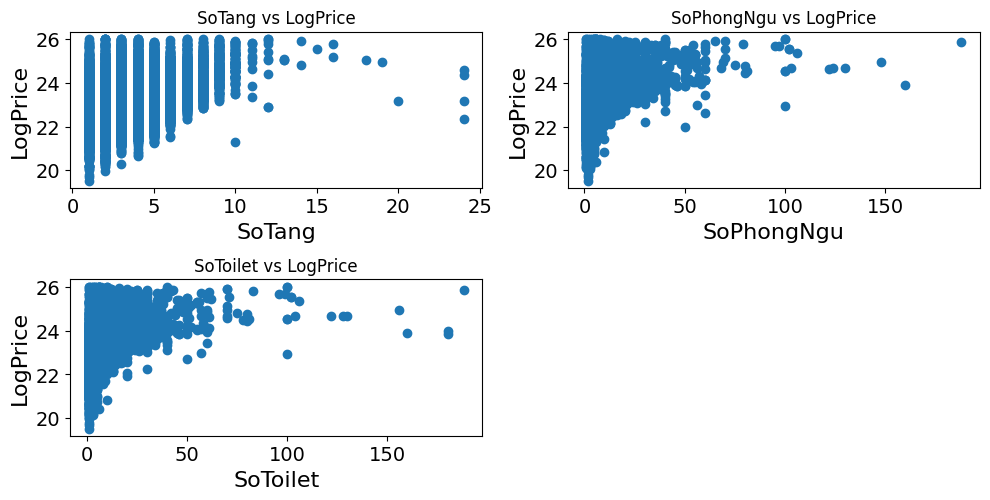

In [81]:
plt.figure(figsize=(10,12))

scatter('SoTang', 1)
scatter('SoPhongNgu', 2)
scatter('SoToilet', 3)

plt.tight_layout()

số phòng ngủ và số Toilet có ảnh hưởng đến mức giá  
số tầng không ảnh hưởng nhiều đến mức giá

C:\Users\huykh\AppData\Local\Temp\ipykernel_5672\1723647498.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_capped['HuongNha'], y=df_capped['USD'], palette="plasma")


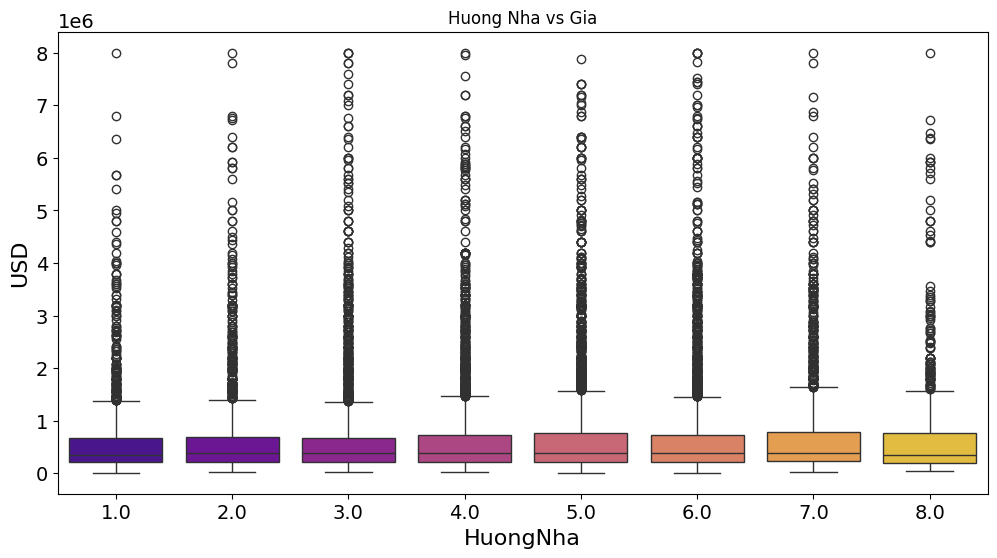

C:\Users\huykh\AppData\Local\Temp\ipykernel_5672\1723647498.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_capped['NoiThat'], y=df_capped['USD'], palette="plasma")


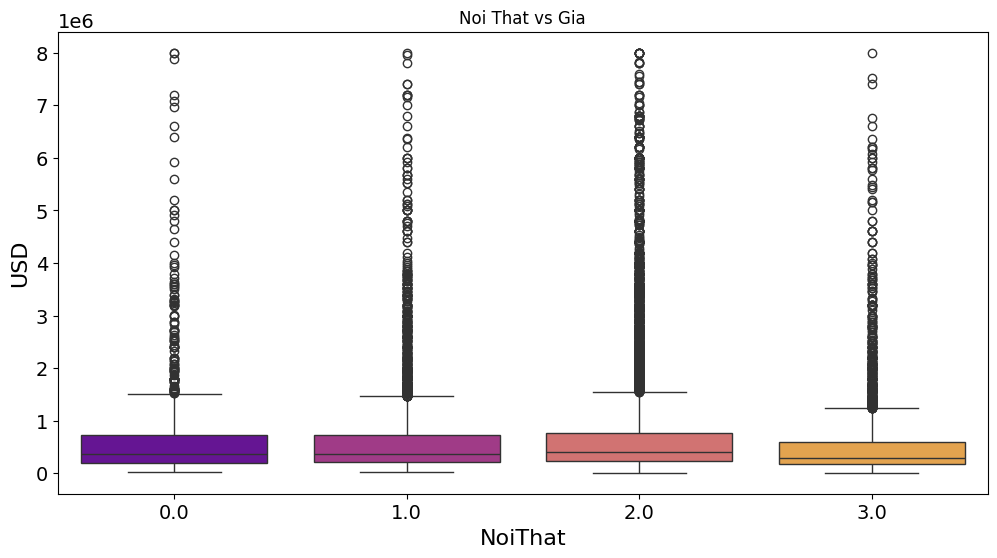

C:\Users\huykh\AppData\Local\Temp\ipykernel_5672\1723647498.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_capped['PhapLy'], y=df_capped['USD'], palette="plasma")


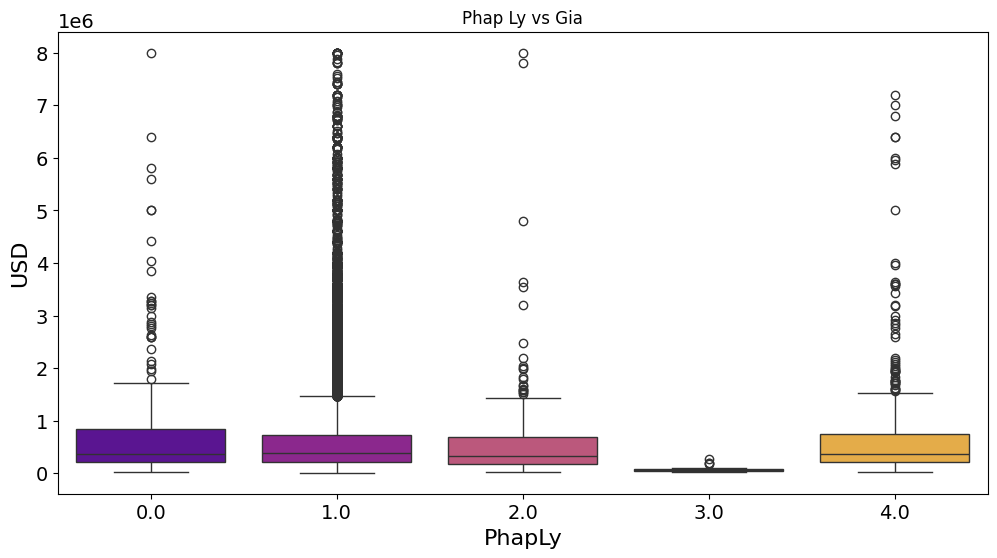

In [82]:
# Setting the figure size for the plots
plt.rcParams['figure.figsize'] = (12, 6)

# Creating the box plots

# sns.boxplot(x=df_raw['HuongBanCong'], y=df_raw['USD'], palette="plasma")
# plt.title('Huong Ban Cong vs Gia')
# plt.show()

sns.boxplot(x=df_capped['HuongNha'], y=df_capped['USD'], palette="plasma")
plt.title('Huong Nha vs Gia')
plt.show()

sns.boxplot(x=df_capped['NoiThat'], y=df_capped['USD'], palette="plasma")
plt.title('Noi That vs Gia')
plt.show()

sns.boxplot(x=df_capped['PhapLy'], y=df_capped['USD'], palette="plasma")
plt.title('Phap Ly vs Gia')
plt.show()

Nội thất, pháp lý ảnh hưởng giá  
Hướng nhà không ảnh hưởng nhiều đến giá

In [38]:
import sys, os
sys.path.append(os.path.abspath('..'))
from modules.preprocessing.convert_modules import address_convert as ac

In [83]:
# Tạo một bản sao của df_raw
df_copy = df_capped.copy()

# Áp dụng hàm chuyển đổi vào bản sao của DataFrame
df_copy['Ward'] = df_copy[['City','District','Ward']].apply(lambda row:ac.ward_deconvert(row['City'],row['District'],row['Ward']),axis=1)
df_copy['District'] = df_copy[['City','District']].apply(lambda row: ac.area_deconvert(row['City'],row['District']),axis=1)
df_copy['City'] = df_copy['City'].apply(ac.region_deconvert)

In [84]:
frame1 = df_copy[['City','District','Ward','NoiThat','HuongNha','PhapLy','USD']]
bins = [40000,90000,250000,118366500]

In [85]:
def Analyst(col):
    temp = frame1.copy()
    table = temp.groupby([col])['USD'].mean()
    temp = temp.merge(table.reset_index(), how='left', on=col)
    cars_bin = ['Low', 'Medium', 'High']
    frame1['range'] = pd.cut(temp['USD_x'], bins, right=False, labels=cars_bin)
    plt.rcParams['figure.figsize'] = (18, 8)
    df = pd.DataFrame(frame1.groupby([col, 'range'])['USD'].mean().unstack(fill_value=0))
    df.plot.bar()
    plt.title('House Range vs Price')
    plt.show()

C:\Users\huykh\AppData\Local\Temp\ipykernel_5672\1922501046.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame1['range'] = pd.cut(temp['USD_x'], bins, right=False, labels=cars_bin)
C:\Users\huykh\AppData\Local\Temp\ipykernel_5672\1922501046.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.DataFrame(frame1.groupby([col, 'range'])['USD'].mean().unstack(fill_value=0))


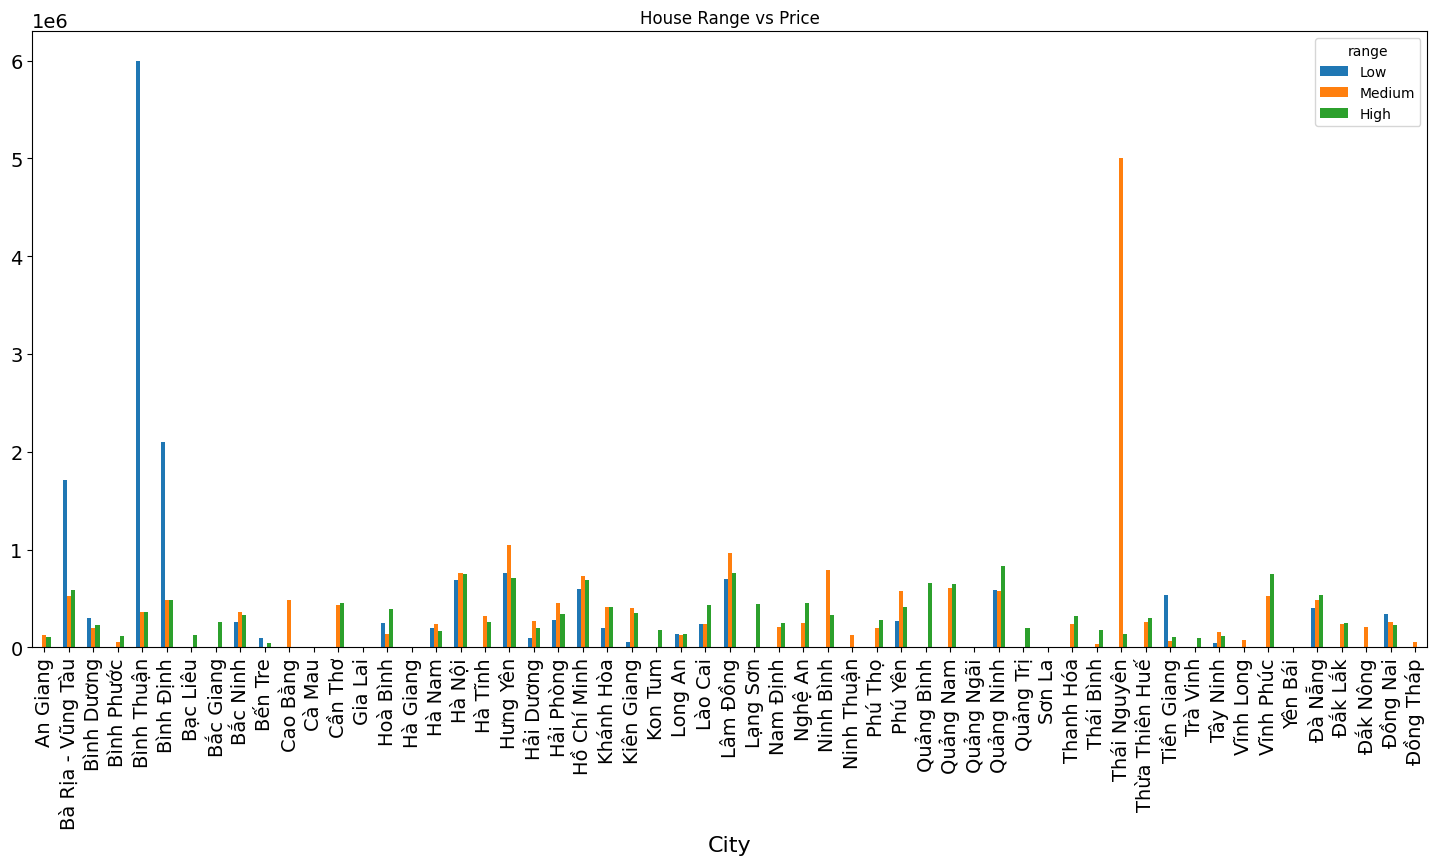

In [86]:
Analyst('City')

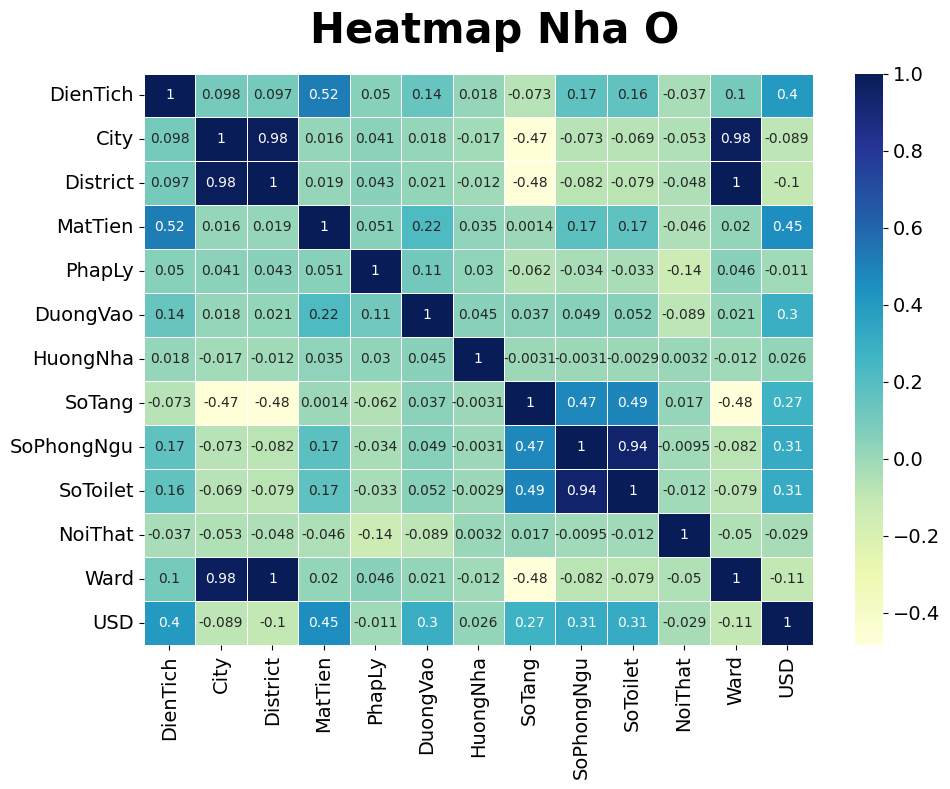

In [87]:
fig = plt.figure(figsize=(10,8))

sns.heatmap(df_capped.corr(), annot = True, cmap='YlGnBu', linewidth=.5)
fig.suptitle('Heatmap Nha O',fontsize=30, fontweight="bold")
pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

ta thấy Thành Phố, Huyện, Đường có mối liên kết mạnh với nhau  
Số Phòng Ngủ, Số Toilet có mối liên kết mạnh với nhau  
mấy thằng còn lại nó có mối liên kết yếu và độc lập với nhau

In [88]:
#Lưu dữ liệu chuẩn hóa vào file csv
df_capped.to_csv('../data/batdongsan/processed/house-dataset.csv',index=False)

## Xây Dựng Mô Hình

In [89]:
df_training = pd.read_csv('../data/batdongsan/processed/house-dataset.csv')

In [90]:
df_training.describe()

,DienTich,City,District,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward,USD
count,24205.000000,24205.000000,24205.000000,17245.000000,24205.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,24205.000000,2.420500e+04
mean,107.193584,42.764264,433.928445,6.506114,1.089238,11.098968,4.518281,3.897583,5.297335,5.254617,1.873580,15532.489899,6.660946e+05
std,172.320227,36.598464,344.943141,5.251218,0.535211,13.343213,1.867371,1.752670,5.997421,6.296579,0.736503,12223.951486,8.682711e+05
min,0.280000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.200000e+04
25%,50.000000,1.000000,8.000000,4.000000,1.000000,5.000000,3.000000,3.000000,3.000000,3.000000,2.000000,328.000000,2.200000e+05
50%,73.500000,54.000000,555.000000,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000,3.800000e+05
75%,110.000000,79.000000,766.000000,7.000000,1.000000,13.500000,6.000000,5.000000,5.000000,5.000000,2.000000,26968.000000,7.200000e+05
max,12468.000000,96.000000,964.000000,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000,8.000000e+06


In [91]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24205 entries, 0 to 24204
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   City        24205 non-null  float64
 2   District    24205 non-null  float64
 3   MatTien     17245 non-null  float64
 4   PhapLy      24205 non-null  float64
 5   DuongVao    15305 non-null  float64
 6   HuongNha    24205 non-null  float64
 7   SoTang      24205 non-null  float64
 8   SoPhongNgu  24205 non-null  float64
 9   SoToilet    24205 non-null  float64
 10  NoiThat     24205 non-null  float64
 11  Ward        24205 non-null  float64
 12  USD         24205 non-null  float64
dtypes: float64(13)
memory usage: 2.4 MB


In [92]:
X = df_training.drop(['USD'], axis=1)
y = df_training['USD']

In [93]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [95]:
# Lưu scaler
joblib.dump(scaler, '../models/house_scaler.pkl')

['../models/house_scaler.pkl']

## Random Forest

In [96]:
# Khởi tạo và huấn luyện mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [97]:
# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 399870.8522521454
R² Score: 0.804972523289347


In [99]:
# Grid Search cho tối ưu hóa siêu tham số của RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo mô hình RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Huấn luyện GridSearch
grid_search.fit(X_train_scaled, y_train)

# Lấy mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán với mô hình tốt nhất
y_pred_rf = best_rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RMSE cho mô hình RandomForest: {rmse_rf}')
print(f'R² score cho mô hình RandomForest: {r2_rf}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
RMSE cho mô hình RandomForest: 398585.26249074086
R² score cho mô hình RandomForest: 0.8062245389505025


## XGBoost

In [102]:
# Tạo và huấn luyện mô hình XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost - R² Score: {r2_xgb}')

XGBoost - Root Mean Squared Error: 391918.7384552467
XGBoost - R² Score: 0.8126523015281201


## LightGBM

In [103]:
# Tạo và huấn luyện mô hình LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'LightGBM - Root Mean Squared Error: {rmse_lgb}')
print(f'LightGBM - R² Score: {r2_lgb}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19364, number of used features: 12
[LightGBM] [Info] Start training from score 661115.079205
LightGBM - Root Mean Squared Error: 376186.50034799543
LightGBM - R² Score: 0.8273912853875452


## kết hợp 3 thuật toán RR, GBR, LightGBM

In [105]:
#kết hợp 3 thuật toán RandomForestRegressor,GradientBoostingRegressor,LGBMRegressor để dự đoán
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xg', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

# Tạo và huấn luyện mô hình Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f'Mean Squared Error: {mse_stacking}')
print(f'Stacking Regressor - Root Mean Squared Error: {rmse_stacking}')
print(f'Stacking Regressor - R² Score: {r2_stacking}')

# Lưu mô hình
joblib.dump(stacking_model, '../models/house_stacking_model.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19364, number of used features: 12
[LightGBM] [Info] Start training from score 661115.079205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 15491, number of used features: 12
[LightGBM] [Info] Start training from score 656945.424551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the

['../models/house_stacking_model.pkl']

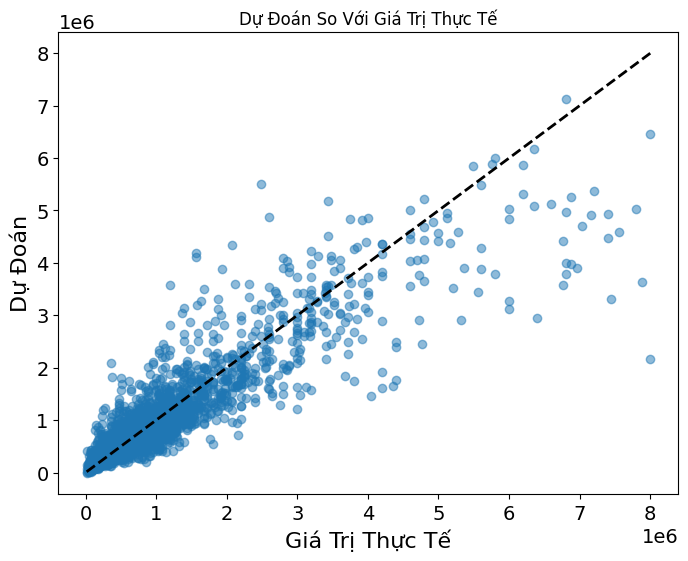

In [106]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.xlabel('Giá Trị Thực Tế')
plt.ylabel('Dự Đoán')
plt.title('Dự Đoán So Với Giá Trị Thực Tế')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

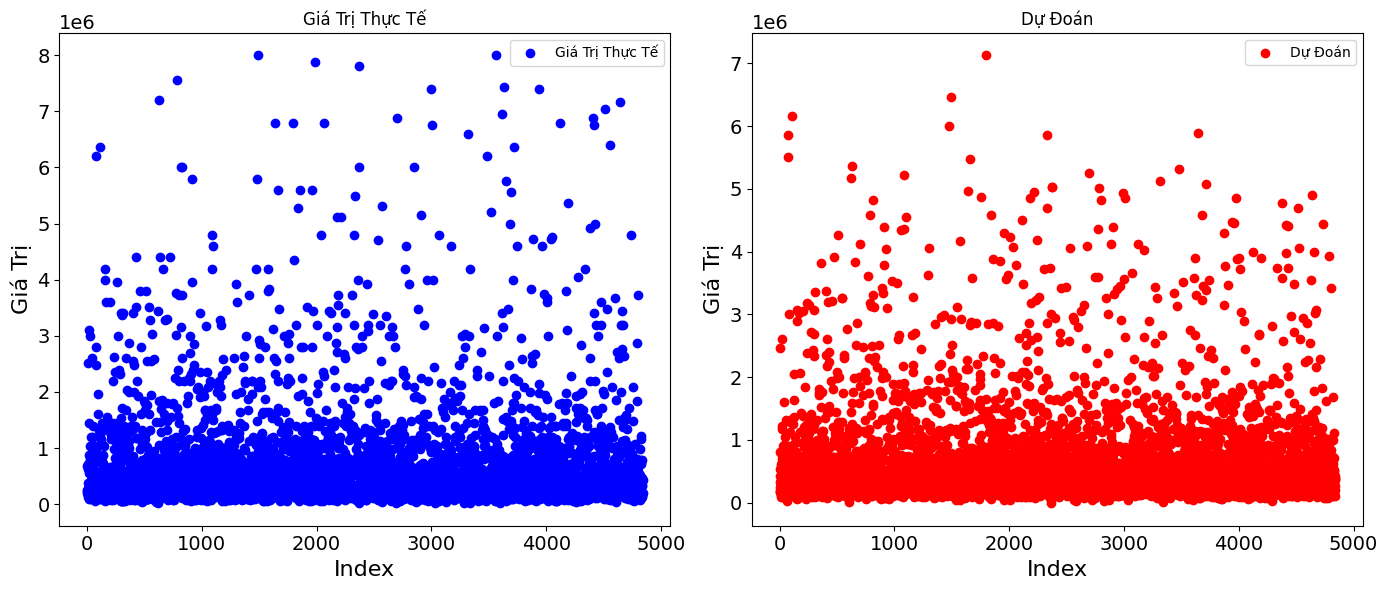

In [107]:
# Vẽ biểu đồ giá trị thực tế
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, 1st subplot
plt.scatter(range(len(y_test)), y_test, color='blue', label='Giá Trị Thực Tế')
plt.xlabel('Index')
plt.ylabel('Giá Trị')
plt.title('Giá Trị Thực Tế')
plt.legend()

# Vẽ biểu đồ dự đoán
plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, 2nd subplot
plt.scatter(range(len(y_pred_stacking)), y_pred_stacking, color='red', label='Dự Đoán')
plt.xlabel('Index')
plt.ylabel('Giá Trị')
plt.title('Dự Đoán')
plt.legend()

plt.tight_layout()
plt.show()